In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
import networkx as nx
import matplotlib.pyplot as plt
import folium
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
eval_df = pd.read_csv('../models/network_evaluation.csv')
eval_df.dropna(inplace = True)
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        143 non-null    object 
 1   Creation Time             143 non-null    object 
 2   Tags                      143 non-null    object 
 3   model                     143 non-null    object 
 4   n_points                  143 non-null    int64  
 5   n_nodes                   143 non-null    int64  
 6   n_edges                   143 non-null    int64  
 7   n_isolated                143 non-null    int64  
 8   DP_tol                    143 non-null    int64  
 9   clustering_alg            143 non-null    object 
 10  min_samples               143 non-null    int64  
 11  metric                    143 non-null    object 
 12  V 1,2                     143 non-null    float64
 13  V 3,4                     143 non-null    float64
 14  V 5       

In [3]:
# parameter summary:
n_points = sorted(eval_df.n_points.unique())
min_samples = sorted(eval_df.min_samples.unique())
v34 = sorted(eval_df['V 3,4'].unique())
v5 = sorted(eval_df['V 5'].unique())
print(f'n_points: {n_points}')
print(f'HDBSCAN min_samples: {min_samples}')
print(f'v34: {v34}')
print(f'v5: {v5}')

n_points: [448382, 796177, 1023428, 1794132, 3109329, 4716292, 5422129]
HDBSCAN min_samples: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, 25, 30, 35, 40, 45]
v34: [0.0001, 0.001, 0.01, 0.1, 1.0]
v5: [1e-07, 1e-06, 1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0]


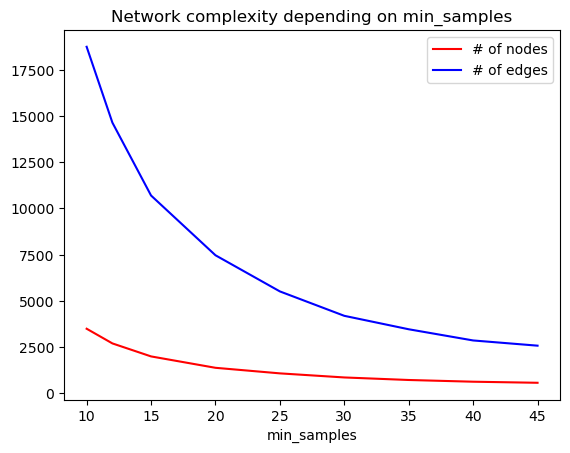

In [4]:
# DEPENDENCE n_edges to min_samples
eval_df.sort_values(by='min_samples', inplace=True)

filter = (eval_df['n_points']==5422129) & (eval_df['V 5']==1e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['test_data/n_trajectories']==752)
x = eval_df[filter]['min_samples']
y1 = eval_df[filter]['n_nodes']
y2 = eval_df[filter]['n_edges']
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='blue')
plt.xlabel('min_samples')
plt.legend(['# of nodes', '# of edges'])

plt.title('Network complexity depending on min_samples')
plt.show()

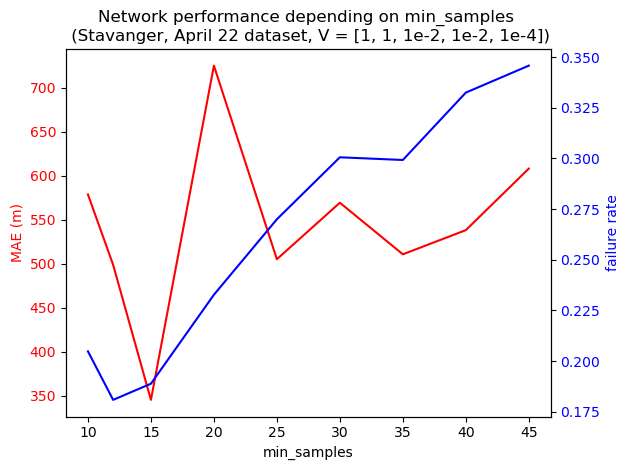

In [5]:
# DEPENDENCE: MIN_SAMPLES (Stavanger)
eval_df.sort_values(by='min_samples', inplace=True)
fig, ax1 = plt.subplots()

ax1.set_xlabel('min_samples')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

filter = (eval_df['n_points']==5422129) & (eval_df['V 5']==1e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['test_data/n_trajectories']==752)
x = eval_df[filter]['min_samples']
y1 = eval_df[filter]['Mean']
y2 = 1-eval_df[filter]['success']
ax1.plot(x, y1, color='red')
ax2.plot(x, y2, color='blue')

plt.title('Network performance depending on min_samples \n (Stavanger, April 22 dataset, V = [1, 1, 1e-2, 1e-2, 1e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

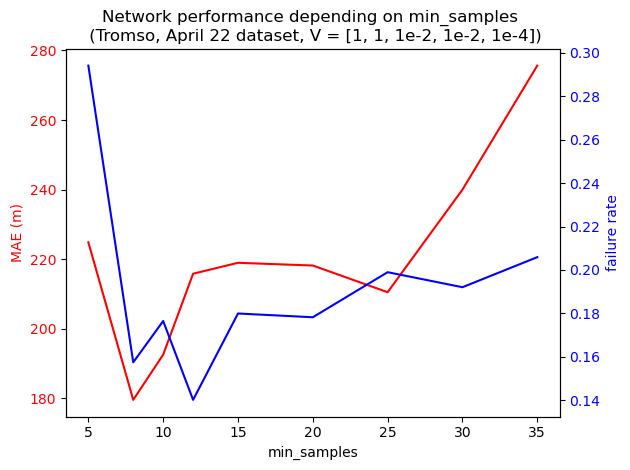

In [6]:
# DEPENDENCE: MIN_SAMPLES (Tromso)
eval_df.sort_values(by='min_samples', inplace=True)
fig, ax1 = plt.subplots()

ax1.set_xlabel('min_samples')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

filter = (eval_df['n_points']==796177) & (eval_df['V 5']==1e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['test_data/n_trajectories']==578)
x = eval_df[filter]['min_samples']
y1 = eval_df[filter]['Mean']
y2 = 1-eval_df[filter]['success']
ax1.plot(x, y1, color='red')
ax2.plot(x, y2, color='blue')

plt.title('Network performance depending on min_samples \n (Tromso, April 22 dataset, V = [1, 1, 1e-2, 1e-2, 1e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

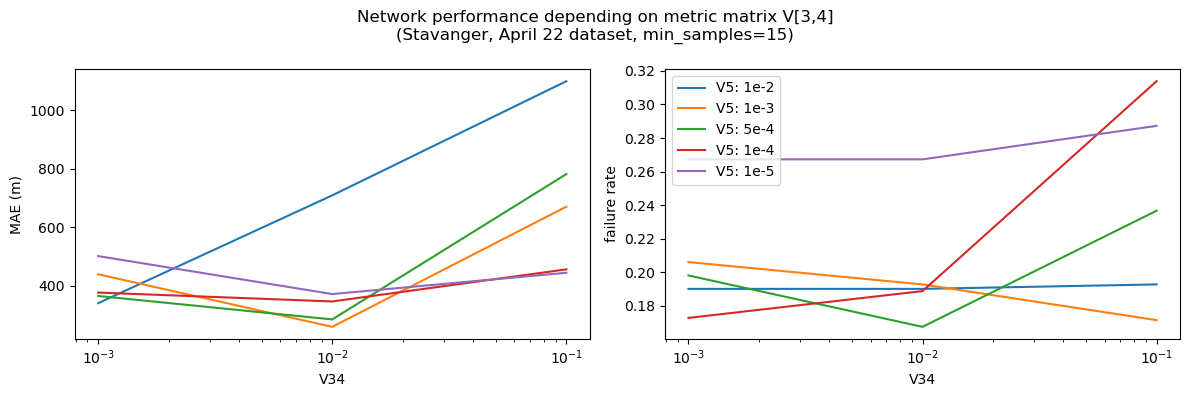

In [7]:
# DEPENDENCE: V 34
eval_df.sort_values(by='V 3,4', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('V34')
axes[0].set_xscale('log')  # Corrected the x-scale
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('V34')  # Added x-label for the second plot
axes[1].set_xscale('log')  # Corrected the x-scale
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [1e-2, 1e-3, 5e-4, 1e-4, 1e-5]:
    filter = (eval_df['n_points'] == 5422129) & (eval_df['V 5'] == val) & (eval_df['min_samples'] == 15) & (eval_df['test_data/n_trajectories'] == 752)
    x = eval_df[filter]['V 3,4']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'V5: {val}' for val in ['1e-2', '1e-3', '5e-4', '1e-4', '1e-5']]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on metric matrix V[3,4]\n(Stavanger, April 22 dataset, min_samples=15)')

fig.tight_layout()  # Adjust layout
plt.show()

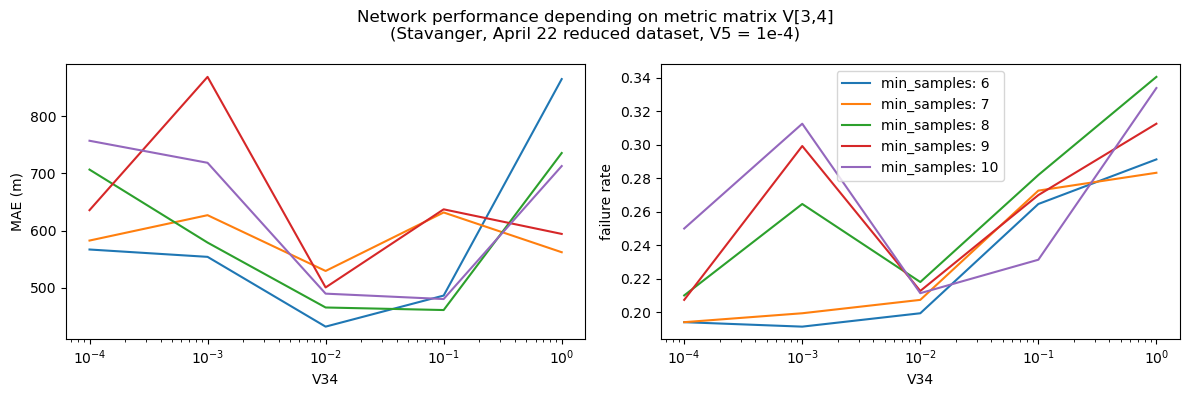

In [8]:
# DEPENDENCE: V 34, smaller dataset
eval_df.sort_values(by='V 3,4', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('V34')
axes[0].set_xscale('log')  # Corrected the x-scale
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('V34')  # Added x-label for the second plot
axes[1].set_xscale('log')  # Corrected the x-scale
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [6, 7, 8, 9, 10]:
    filter = (eval_df['n_points'] == 448382) & (eval_df['V 5'] == 1e-4) & (eval_df['min_samples'] == val) & (eval_df['test_data/n_trajectories'] == 752)
    x = eval_df[filter]['V 3,4']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'min_samples: {val}' for val in [6, 7, 8, 9, 10]]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on metric matrix V[3,4]\n(Stavanger, April 22 reduced dataset, V5 = 1e-4)')

fig.tight_layout()  # Adjust layout
plt.show()

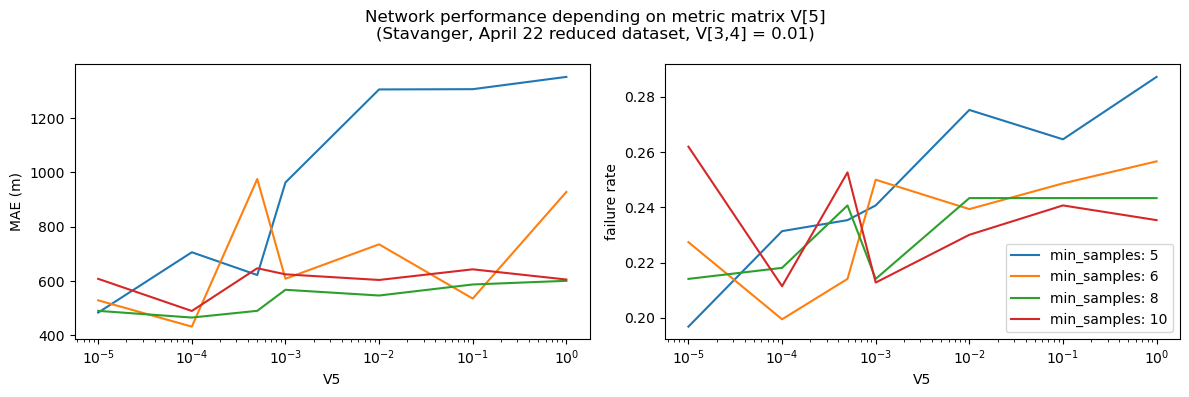

In [9]:
# DEPENDENCE: V 5, smaller dataset
eval_df.sort_values(by='V 5', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('V5')
axes[0].set_xscale('log')  # Corrected the x-scale
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('V5')  # Added x-label for the second plot
axes[1].set_xscale('log')  # Corrected the x-scale
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [5, 6, 8, 10]:
    filter = (eval_df['n_points'] == 448382) & (eval_df['V 3,4'] == 0.01) & (eval_df['min_samples'] == val) & (eval_df['test_data/n_trajectories'] == 752)
    x = eval_df[filter]['V 5']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'min_samples: {val}' for val in [5, 6, 8, 10]]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on metric matrix V[5]\n(Stavanger, April 22 reduced dataset, V[3,4] = 0.01)')

fig.tight_layout()  # Adjust layout
plt.show()

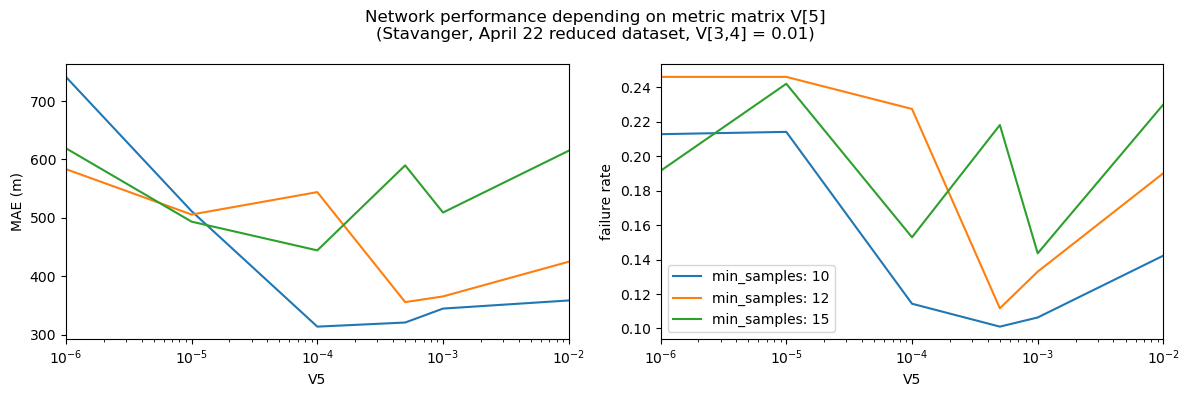

In [16]:
# DEPENDENCE: V 5, medium dataset
eval_df.sort_values(by='V 5', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('V5')
axes[0].set_xlim([1e-6, 1e-2])
axes[0].set_xscale('log')  # Corrected the x-scale
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('V5')  # Added x-label for the second plot
axes[1].set_xlim([1e-6, 1e-2])
axes[1].set_xscale('log')  # Corrected the x-scale
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [10, 12, 15]:
    filter = (eval_df['n_points'] == 1794132) & (eval_df['V 3,4'] == 0.01) & (eval_df['min_samples'] == val) & (eval_df['test_data/n_trajectories'] == 752) & (eval_df['DP_tol']==10)
    x = eval_df[filter]['V 5']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'min_samples: {val}' for val in [10, 12, 15]]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on metric matrix V[5]\n(Stavanger, April 22 medium dataset, V[3,4] = 0.01)')

fig.tight_layout()  # Adjust layout
plt.show()

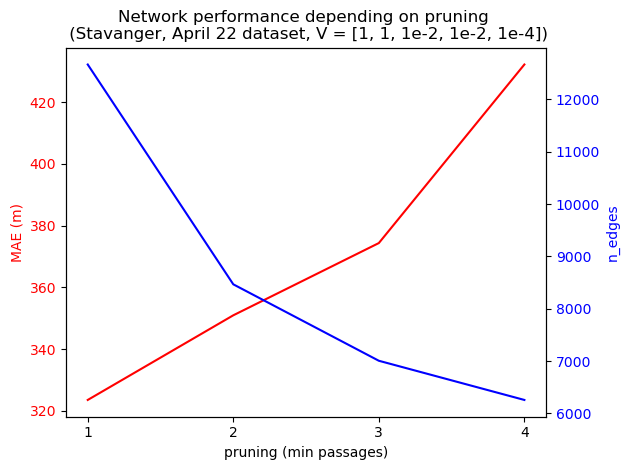

In [17]:
# DEPENDENCE: pruning
eval_df.sort_values(by='pruning', inplace=True)
fig, ax1 = plt.subplots()

ax1.set_xlabel('pruning (min passages)')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks([1, 2, 3, 4])

ax2 = ax1.twinx()  
ax2.set_ylabel('n_edges', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

filter = (eval_df['n_points']==5422129) & (eval_df['V 5']==1e-3) & (eval_df['V 3,4']==1e-2) & (eval_df['test_data/n_trajectories']==1504)
x = eval_df[filter]['pruning']
y1 = eval_df[filter]['Mean']
y2 = eval_df[filter]['n_edges']
ax1.plot(x, y1, color='red')
ax2.plot(x, y2, color='blue')

plt.title('Network performance depending on pruning \n (Stavanger, April 22 dataset, V = [1, 1, 1e-2, 1e-2, 1e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

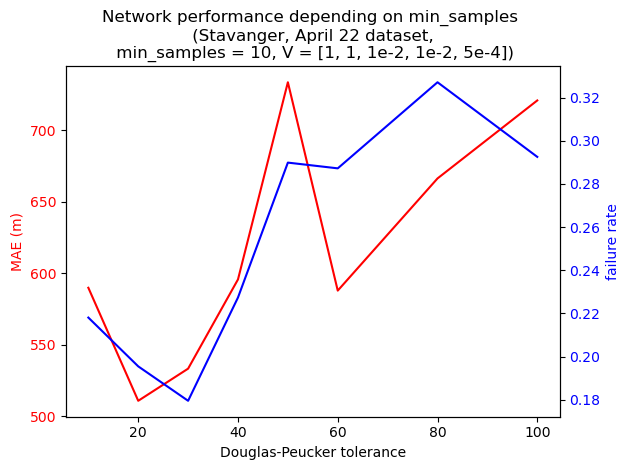

In [27]:
# DEPENDENCE on DP_tol
eval_df.sort_values(by='DP_tol', inplace=True)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Douglas-Peucker tolerance')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

for val in [15]:
    filter = (eval_df['n_points']==1794132) & (eval_df['V 5']==5e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['test_data/n_trajectories']==752) & (eval_df['min_samples']==val)
    x = eval_df[filter]['DP_tol']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    ax1.plot(x, y1, color='red')
    ax2.plot(x, y2, color='blue')

plt.title('Network performance depending on min_samples \n (Stavanger, April 22 dataset, \n min_samples = 10, V = [1, 1, 1e-2, 1e-2, 5e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()